In [47]:
import sys
import gym
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple
import time
import configparser

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical
from torch.distributions import OneHotCategorical
from torch.distributions import MultivariateNormal
import virtualTB

env = gym.make('VirtualTB-v0')
env_action_space = env.action_space.shape[0]
            
env.close()

In [67]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_outputs),
            nn.Tanh()
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = F.softmax(probs,dim=1)
#         return dist, probs, value
        return dist, value

In [68]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [76]:
a = Categorical(torch.tensor([1.,2.,3.]))
a

Categorical(probs: torch.Size([3]))

In [71]:
from gym import wrappers
from copy import deepcopy
import pickle
import matplotlib
import matplotlib.pyplot as plt

FLOAT = torch.FloatTensor
LONG = torch.LongTensor
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

env = gym.make('VirtualTB-v0')

env.seed(0)
np.random.seed(0)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

lr = 1e-4

model = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters())

rewards = []
test_reward_record = []
ctr_record = []
reward_record = []
value_loss_record = []
policy_loss_record = []

test_ep = 100


for i_episode in range(10000):
    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0
    
    state = torch.Tensor([env.reset()])

    episode_reward = 0
    
    while True:
        state = torch.FloatTensor(state).to(device)
#         print(state)

        dist, probs, value = model(state)
        action = probs.squeeze(0)
        log_prob = dist
        
#         dist, value = model(state)
#         action = dist.sample()
        next_state, reward, done, _ = env.step(action.detach().cpu().numpy())
#         print(dist)
#         print(action)
        
        log_prob = dist.sample()
#         print(log_prob)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

        episode_reward += reward
        reward_record.append(reward)

        state = next_state

        # 可以加提前终止的机制

        if done:
            break
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)

    advantage = returns - values

    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
            
    rewards.append(episode_reward)
    
    
    if i_episode % test_ep == 0:
        episode_reward = 0
        episode_step = 0
        for i in range(50):
            state = torch.Tensor([env.reset()])
            while True:
                state = torch.FloatTensor(state).to(device)
                probs, value = model(state)
        #         print(action)
                action = probs.squeeze(0)
                next_state, reward, done, _ = env.step(action.detach().cpu().numpy())
                
                episode_reward += reward
                episode_step += 1

#                 next_state = torch.Tensor([next_state])

                state = next_state
                if done:
                    break

        # rewards.append(episode_reward)
        test_reward_record.append(episode_reward / 50)
        ctr_record.append(episode_reward / episode_step/ 10)
        print("Episode: {}, total numsteps: {}, average reward: {}, CTR: {}".format(i_episode, episode_step, episode_reward / 50, episode_reward / episode_step/ 10))
    
env.close()

tensor([[ 0.0915, -0.0398,  0.1450,  0.0270,  0.0124, -0.1909, -0.0147, -0.1095,
         -0.1438,  0.0675, -0.0169,  0.0272, -0.0599,  0.0155,  0.1594,  0.0826,
          0.0063,  0.0275,  0.0402,  0.0421,  0.1550, -0.1479,  0.0258, -0.1217,
          0.3501, -0.1709,  0.0099]], device='cuda:0', grad_fn=<TanhBackward>)
tensor([[0.0399, 0.0350, 0.0421, 0.0374, 0.0369, 0.0301, 0.0359, 0.0326, 0.0315,
         0.0390, 0.0358, 0.0374, 0.0343, 0.0370, 0.0427, 0.0396, 0.0367, 0.0374,
         0.0379, 0.0380, 0.0425, 0.0314, 0.0374, 0.0322, 0.0517, 0.0307, 0.0368]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)


AttributeError: 'Tensor' object has no attribute 'sample'

In [ ]:
torch.save(actor,'a2c_actor.pt')
torch.save(critic,'a2c_critic.pt')
# model = torch.load('ddpg.pt')

In [3]:
with open('./rewards_record.pkl', 'wb') as f:
    pickle.dump(rewards, f)
with open('./test_reward_record.pkl', 'wb') as f:
    pickle.dump(test_reward_record, f)
with open('./ctr_record.pkl', 'wb') as f:
    pickle.dump(ctr_record, f)
with open('./reward_record.pkl', 'wb') as f:
    pickle.dump(reward_record, f)
with open('./value_loss_record.pkl', 'wb') as f:
    pickle.dump(value_loss_record, f)
with open('./policy_loss.pkl', 'wb') as f:
    pickle.dump(policy_loss_record, f)    

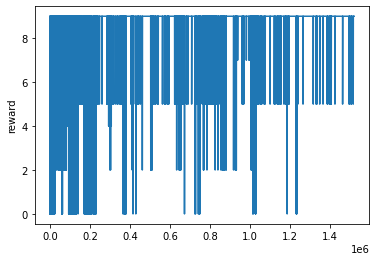

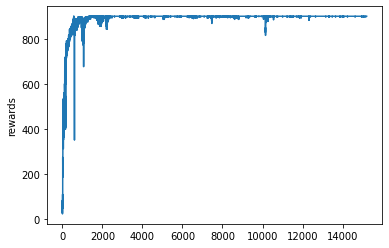

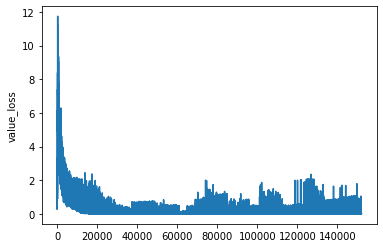

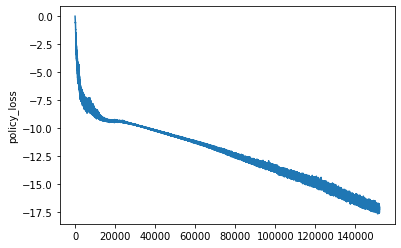

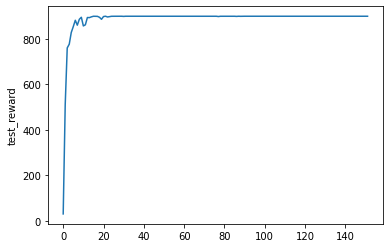

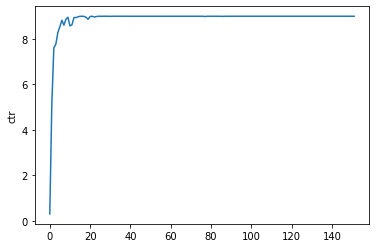

In [4]:
def getInfo():
    '''返回六个列表,分别用于保存reward/rewards/value_loss/policy_loss/test_reward/ctr'''
    info = list()
    fileNames = [
        './reward_record.pkl',
        './rewards_record.pkl',
        './value_loss_record.pkl',
        './policy_loss.pkl',
        './test_reward_record.pkl',
        './ctr_record.pkl']  # 文件的名字
    for name in fileNames:
        with open(name, 'rb') as f:
            item = pickle.load(f)
            info.append(item)
    return info

reward_record, rewards, value_loss_record, policy_loss_record, test_reward_record,ctr_record = getInfo()

plt.plot(reward_record)
plt.ylabel('reward')
plt.show()

plt.plot(rewards)
plt.ylabel('rewards')
plt.show()

plt.plot(value_loss_record)
plt.ylabel('value_loss')
plt.show()

plt.plot(policy_loss_record)
plt.ylabel('policy_loss')
plt.show()

plt.plot(test_reward_record)
plt.ylabel('test_reward')
plt.show()

plt.plot(ctr_record)
plt.ylabel('ctr')
plt.show()